In [5]:

##### ONLY UNCOMMENT AND RUN IFF YOU"RE IN COLAB

import sys
#!git clone https://github.com/krmerchant/detr.git
#sys.path.insert(0, '/content/detr')
## download the Penn-Fudan dataset
#!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
#!unzip -q PennFudanPed.zip
#DATA_ROOT='/content/PennFudanPed'


#!pip install torchmetrics



In [25]:
##### If you're running on local setup

#!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
#!unzip -q PennFudanPed.zip

DATA_ROOT='./'

In [27]:

import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2


# Add the x directory to Python's path
from models.matcher import HungarianMatcher
from models.detr import SetCriterion

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2



In [28]:
num_classes = 2
num_queries = 10
null_class_coef = 0.1
BATCH_SIZE = 8
LR = 1e-5

device = torch.device('cuda')

## Dataset Preparation

In [9]:
import torch

def pascal_to_coco_tensor(pascal_bboxes):
    """
    Convert Pascal VOC bounding boxes to COCO format for Nx4 tensor.

    Pascal VOC format: [xmin, ymin, xmax, ymax]
    COCO format: [x, y, width, height]

    Args:
        pascal_bboxes (torch.Tensor): Tensor of shape (N, 4) with Pascal format boxes

    Returns:
        torch.Tensor: Tensor of shape (N, 4) with COCO format boxes
    """
    if pascal_bboxes.shape[-1] != 4:
        raise ValueError(f"Expected last dimension to be 4, got {pascal_bboxes.shape[-1]}")

    coco_bboxes = torch.zeros_like(pascal_bboxes)

    coco_bboxes[:, 0] = pascal_bboxes[:, 0]  # x = xmin
    coco_bboxes[:, 1] = pascal_bboxes[:, 1]  # y = ymin
    coco_bboxes[:, 2] = pascal_bboxes[:, 2] - pascal_bboxes[:, 0]  # width = xmax - xmin
    coco_bboxes[:, 3] = pascal_bboxes[:, 3] - pascal_bboxes[:, 1]  # height = ymax - ymin

    return coco_bboxes


In [22]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

import albumentations as A
from albumentations.core.bbox_utils import normalize_bboxes

def collate_fn(batch):
    return tuple(zip(*batch))

class PennFudanDataset(torch.utils.data.Dataset):
    '''
    Boiler plate from: https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html
    '''
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.annot = list(sorted(os.listdir(os.path.join(root, "Annotation"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        annot_path = os.path.join(self.root, "Annotation", self.annot[idx])
        img = Image.open(img_path).convert("RGB")

        # get bounding box coordinates for each mask
        boxes = []
        with open(annot_path) as fin:
          for line in fin:
            if 'Xmin' in line:
              bounds = line.replace('(','').replace(')','').replace(',','').replace('-','').split()[11:]
              bounds = [int(x) for x in bounds]
              boxes.append(bounds)

        boxes = torch.as_tensor(boxes, dtype=torch.float32, )
        boxes = pascal_to_coco_tensor(boxes)


        # there is only one class (besides background)
        labels = torch.ones((len(boxes),), dtype=torch.int64)

        # define id for this image
        image_id = torch.tensor([idx])


        convert_to_tensor = transforms.ToTensor()
        img = convert_to_tensor(img)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        img = normalize(img)
        _,h,w = img.shape
        normalization_matrix = torch.tensor([w,h,w,h])
        boxes = boxes/normalization_matrix
        # put it into the dict
        target = {}
        labels = torch.zeros(labels.shape,dtype=torch.long)
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target, image_id

    def __len__(self):
        return len(self.imgs)

In [13]:

from models.backbone import Backbone, Joiner
from models.detr import DETR, PostProcess
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer

def make_model(pretrained=True,use_dino_resnet=False):
        hidden_dim = 256
        backbone = Backbone("resnet50", train_backbone=True, return_interm_layers=False, dilation=False,use_dino=use_dino_resnet)
        pos_enc = PositionEmbeddingSine(hidden_dim // 2, normalize=True)
        backbone_with_pos_enc = Joiner(backbone, pos_enc)
        backbone_with_pos_enc.num_channels = backbone.num_channels
        transformer = Transformer(d_model=hidden_dim, return_intermediate_dec=True)
        model = DETR(backbone_with_pos_enc, transformer, num_classes=91, num_queries=100)
        checkpoint = torch.hub.load_state_dict_from_url(
                url="https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth", map_location="cpu", check_hash=True
            )
        #model.load_state_dict(checkpoint["model"])
        return model


def make_model_resnet101(pretrained=True,use_dino_resnet=False):
        hidden_dim = 256
        backbone = Backbone("resnet50", train_backbone=True, return_interm_layers=False, dilation=False,use_dino=use_dino_resnet)
        pos_enc = PositionEmbeddingSine(hidden_dim // 2, normalize=True)
        backbone_with_pos_enc = Joiner(backbone, pos_enc)
        backbone_with_pos_enc.num_channels = backbone.num_channels
        transformer = Transformer(d_model=hidden_dim, return_intermediate_dec=True)
        model = DETR(backbone_with_pos_enc, transformer, num_classes=91, num_queries=100)
        checkpoint = torch.hub.load_state_dict_from_url(
                url="https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth", map_location="cpu", check_hash=True
            )
        model.load_state_dict(checkpoint["model"])
        return model


class DETR_FineTune(nn.Module):

    def __init__(self,num_classes,num_queries,use_dino_resenet=False,use_resnet_101=False):
        super(DETR_FineTune,self).__init__( )
        self.num_classes = num_classes
        self.num_queries = num_queries
        if use_resnet_101:
          self.model = make_model_resnet101()
        else:
          self.model = make_model(use_dino_resnet=use_dino_resenet)
        self.in_features = self.model.class_embed.in_features
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries

    def forward(self,images):
        return self.model(images)



detr = DETR_FineTune(2,100,use_resnet_101=True)

/home/komelmerchant/Dropbox/JHUCourseTracking/deeplearningwithtransformers/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/komelmerchant/Dropbox/JHUCourseTracking/deeplearningwithtransformers/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
import torch
from torchmetrics.detection import MeanAveragePrecision

from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class Trainer(object):
    def __init__(self, model, criterion, optimizer, device):
        self.model = model.to(device)
        self.criterion = criterion.to(device)
        self.optimizer = optimizer
        self.device = device
        self.scheduler =  ReduceLROnPlateau(optimizer, "min")
        # Initialize the metric
        self.metric = MeanAveragePrecision(box_format='cxcywh',iou_type="bbox")
        self.writer = None

    def accumulate_bbox_preds(self, output, targets, confidence_threshold=0.5):
        """
        Prepare model outputs and targets for mAP computation.

        Args:
            output: Model output dict with 'pred_logits' and 'pred_boxes'
            targets: List of target dicts with 'boxes' and 'labels'
            confidence_threshold: Minimum confidence score to keep predictions

        Returns:
            tuple: (batch_preds, batch_targets) formatted for torchmetrics
        """
        batch_preds = []
        batch_targets = []

        batch_size = len(targets)

        for i in range(batch_size):
            # Get predictions for this image
            pred_logits = output['pred_logits'][i]  # [num_queries, num_classes]
            pred_boxes = output['pred_boxes'][i]    # [num_queries, 4]

            # Get probabilities and predicted classes
            pred_probs = pred_logits.softmax(-1)
            pred_scores, pred_labels = pred_probs.max(-1)

            # Filter out background class and low confidence predictions
            keep = (pred_labels != (self.model.num_classes - 1)) & (pred_scores > confidence_threshold)

            pred_dict = {
                'boxes': pred_boxes[keep].cpu(),
                'scores': pred_scores[keep].cpu(),
                'labels': pred_labels[keep].cpu()
            }
            batch_preds.append(pred_dict)

            # Format ground truth targets
            target_dict = {
                'boxes': targets[i]['boxes'].cpu(),
                'labels': targets[i]['labels'].cpu()
            }
            batch_targets.append(target_dict)

        return batch_preds, batch_targets





    def train(self, train_loader, validate_loader, training_job_id, num_epochs = 30):
        best_loss = 10**5
        print("Starting training job....")

        best_map = 0
        self.writer = SummaryWriter(f'runs/experiment_{training_job_id}')

        for epoch in range(num_epochs):
            train_loss = self.train_epoch(train_loader, epoch)
            valid_loss, map_results = self.validate(validate_loader)

            print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))

            self.writer.add_scalar('Loss/train', train_loss.avg, epoch)
            self.writer.add_scalar('Loss/valid', valid_loss.avg, epoch)
            self.writer.add_scalar('Accuracy/valid/mAP',map_results['map'], epoch)
            self.writer.add_scalar('Accuracy/valid/mAP_50',map_results['map_50'], epoch)
            self.writer.add_scalar('Accuracy/valid/mAP_75',map_results['map_75'], epoch)
            self.writer.flush()  # Force write to disk now
            if self.scheduler is not None:
              self.scheduler.step(valid_loss.avg)
            if map_results['map'] > best_map:
              best_map = map_results['map']
            if valid_loss.avg < best_loss:
                best_loss = valid_loss.avg
                print('Best model found for Fold {} in Epoch {}........Saving Model'.format(training_job_id,epoch+1))
                torch.save(self.model.state_dict(), f'detr_best_{training_job_id}.pth')
        return best_map,best_loss,train_loss,valid_loss
    def train_epoch(self,data_loader, epoch):
        self.model.train()
        self.criterion.train()

        summary_loss = AverageMeter()
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets,_) in enumerate(tk0):

            images = list(image.to(self.device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


            output = self.model(images)

            loss_dict = self.criterion(output, targets)
            weight_dict = self.criterion.weight_dict
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            summary_loss.update(losses.item(),BATCH_SIZE)
            if self.writer is not None:
              self.writer.add_scalar('Loss/step/train', summary_loss.avg, epoch * len(data_loader) + step)
              self.writer.flush()  # Force write to disk now
            tk0.set_postfix(loss=summary_loss.avg,lr=self.optimizer.param_groups[0]['lr'] )

        return summary_loss


    def validate(self, data_loader):
        self.model.eval()
        self.criterion.eval()
        summary_loss = AverageMeter()
        # Reset metric at start of validation
        self.metric.reset()
        with torch.no_grad():
            tk0 = tqdm(data_loader, total=len(data_loader))
            for step, (images, targets,_) in enumerate(tk0):

                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                output = self.model(images)

                loss_dict = self.criterion(output, targets)
                weight_dict = self.criterion.weight_dict

                losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)


                preds, gts = self.accumulate_bbox_preds(output, targets, confidence_threshold=0.5)
                self.metric.update(preds, gts)

                summary_loss.update(losses.item(),BATCH_SIZE)
                tk0.set_postfix(loss=summary_loss.avg)
        results = self.metric.compute()

        print(f"\nmAP: {results['map']:.4f}")           # Overall mAP


        return summary_loss, results



In [15]:
# Some "Factory Function" for setting up by fixed experiments



def build_standard_trainer():
  matcher = HungarianMatcher()
  weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
  losses = ['labels', 'boxes', 'cardinality']
  criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
  detr_model =  DETR_FineTune(num_classes, num_queries,use_dino_resenet=False)
  optimizer = torch.optim.AdamW(detr_model.parameters(), lr=LR)
  trainer = Trainer(model=detr_model, criterion = criterion, optimizer=optimizer,device=device )
  return trainer




def build_trainer_with_dino_resnet():
  ''' This doesnt work ... at all. We probably need to pretrain this on COCO, which would take more compute
  and time than I have availible'''
  matcher = HungarianMatcher()
  weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
  losses = ['labels', 'boxes', 'cardinality']
  criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
  detr_model =  DETR_FineTune(num_classes, num_queries,use_dino_resenet=True)
  optimizer = torch.optim.AdamW(detr_model.parameters(), lr=LR)
  trainer = Trainer(model=detr_model, criterion = criterion, optimizer=optimizer,device=device )
  return trainer

def build_trainer_with_resnet_101():
  matcher = HungarianMatcher()
  weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
  losses = ['labels', 'boxes', 'cardinality']
  criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
  detr_model =  DETR_FineTune(num_classes, num_queries,use_resnet_101=True)
  optimizer = torch.optim.AdamW(detr_model.parameters(), lr=LR)
  trainer = Trainer(model=detr_model, criterion = criterion, optimizer=optimizer,device=device )
  return trainer




In [21]:
class ExperimentExecutor:
    """
    Class to execute and visualize K-Fold cross-validation experiments.
    """

    def __init__(self, dataset, trainer_factory, n_folds=5, num_epochs=30, seed=42):
        """
        Initialize the ExperimentExecutor.

        Args:
            dataset: PennFudanDataset instance
            trainer_factory: Function that returns a new Trainer instance when called
            n_folds: Number of folds for cross-validation
            num_epochs: Number of epochs to train each fold
            seed: Random seed for reproducibility
        """
        self.dataset = dataset
        self.trainer_factory = trainer_factory
        self.n_folds = n_folds
        self.num_epochs = num_epochs
        self.seed = seed
        self.results = None

    def run_kfold_cross_validation(self):
        """
        Run K-Fold cross-validation on the DETR model.

        Returns:
            pd.DataFrame: Results containing best mAP and loss for each fold
        """
        from sklearn.model_selection import KFold

        # Set random seed for reproducibility
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        # Get indices for all samples
        indices = list(range(len(self.dataset)))

        # Initialize KFold
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.seed)

        # Store results for each fold
        fold_results = {
            'fold': [],
            'best_map': [],
            'best_loss': [],
            'final_train_loss': [],
            'final_val_loss': []
        }

        # Iterate through folds
        for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
            print(f"\n{'='*60}")
            print(f"FOLD {fold + 1}/{self.n_folds}")
            print(f"{'='*60}")
            print(f"Train samples: {len(train_idx)}, Validation samples: {len(val_idx)}")

            # Create data samplers and loaders
            train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
            val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

            train_loader = DataLoader(
                self.dataset,
                batch_size=BATCH_SIZE,
                sampler=train_sampler,
                num_workers=4,
                collate_fn=collate_fn
            )

            val_loader = DataLoader(
                self.dataset,
                batch_size=BATCH_SIZE,
                sampler=val_sampler,
                num_workers=4,
                collate_fn=collate_fn
            )

            # Get a fresh trainer instance for this fold
            trainer = self.trainer_factory()

            # Train the model
            training_job_id = f"fold_{fold + 1}"
            best_map, best_loss, final_train_loss, final_val_loss = trainer.train(
                train_loader,
                val_loader,
                training_job_id,
                num_epochs=self.num_epochs
            )

            # Store results
            fold_results['fold'].append(fold + 1)
            fold_results['best_map'].append(best_map)
            fold_results['best_loss'].append(best_loss)
            fold_results['final_train_loss'].append(final_train_loss)
            fold_results['final_val_loss'].append(final_val_loss)

            print(f"\nFold {fold + 1} Results:")
            print(f"  Best mAP: {best_map:.4f}")
            print(f"  Best Loss: {best_loss:.4f}")

            # Clean up to free memory
            del trainer
            torch.cuda.empty_cache()

        # Calculate and print average results
        print(f"\n{'='*60}")
        print("CROSS-VALIDATION SUMMARY")
        print(f"{'='*60}")

        self.results = pd.DataFrame(fold_results)
        print(self.results.to_string(index=False))

        print(f"\nAverage mAP: {np.mean(fold_results['best_map']):.4f} ± {np.std(fold_results['best_map']):.4f}")
        print(f"Average Best Loss: {np.mean(fold_results['best_loss']):.4f} ± {np.std(fold_results['best_loss']):.4f}")

        return self.results



    def get_summary_statistics(self):
        """
        Get summary statistics of the cross-validation results.

        Returns:
            dict: Dictionary containing summary statistics
        """
        if self.results is None:
            raise ValueError("No results available. Run run_kfold_cross_validation() first.")

        summary = {
            'mAP': {
                'mean': np.mean(self.results['best_map']),
                'std': np.std(self.results['best_map']),
                'min': np.min(self.results['best_map']),
                'max': np.max(self.results['best_map']),
                'median': np.median(self.results['best_map'])
            },
            'loss': {
                'mean': np.mean(self.results['best_loss']),
                'std': np.std(self.results['best_loss']),
                'min': np.min(self.results['best_loss']),
                'max': np.max(self.results['best_loss']),
                'median': np.median(self.results['best_loss'])
            }
        }

        return summary

    def save_results(self, filepath='kfold_results.csv'):
        """
        Save the results to a CSV file.

        Args:
            filepath: Path to save the CSV file
        """
        if self.results is None:
            raise ValueError("No results to save. Run run_kfold_cross_validation() first.")

        self.results.to_csv(filepath, index=False)
        print(f"Results saved to {filepath}")

In [34]:
resnet_50 = ExperimentExecutor(dataset, build_standard_trainer, n_folds=5, num_epochs=100, seed=42)
resnet_50.run_kfold_cross_validation()



FOLD 1/5
Train samples: 136, Validation samples: 34
Starting training job....


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 1| TRAIN_LOSS 2.4903206264271454| VALID_LOSS 2.5110030651092528|
Best model found for Fold fold_1 in Epoch 1........Saving Model


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 2| TRAIN_LOSS 2.186706963707419| VALID_LOSS 2.204039430618286|
Best model found for Fold fold_1 in Epoch 2........Saving Model


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 3| TRAIN_LOSS 2.042316303533666| VALID_LOSS 2.0445508480072023|
Best model found for Fold fold_1 in Epoch 3........Saving Model


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 4| TRAIN_LOSS 1.946305380148046| VALID_LOSS 2.188259649276733|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 5| TRAIN_LOSS 1.883935065830455| VALID_LOSS 2.0649100065231325|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 6| TRAIN_LOSS 1.8391882672029383| VALID_LOSS 2.1076142311096193|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 7| TRAIN_LOSS 1.812461123746984| VALID_LOSS 2.013675832748413|
Best model found for Fold fold_1 in Epoch 7........Saving Model


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 8| TRAIN_LOSS 1.7495871642056633| VALID_LOSS 2.0160571575164794|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 9| TRAIN_LOSS 1.717918403008405| VALID_LOSS 2.0316707849502564|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 10| TRAIN_LOSS 1.6620992912965662| VALID_LOSS 2.1195263385772707|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 11| TRAIN_LOSS 1.637784011223737| VALID_LOSS 2.0618366956710816|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 12| TRAIN_LOSS 1.5748988109476425| VALID_LOSS 2.1901766300201415|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 13| TRAIN_LOSS 1.5375905177172493| VALID_LOSS 2.135229229927063|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 14| TRAIN_LOSS 1.434537782388575| VALID_LOSS 2.1541049480438232|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 15| TRAIN_LOSS 1.387764439863317| VALID_LOSS 2.3888046741485596|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 16| TRAIN_LOSS 1.3146594201817232| VALID_LOSS 2.4803157329559324|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 17| TRAIN_LOSS 1.2859331930384916| VALID_LOSS 2.607958269119263|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 18| TRAIN_LOSS 1.2690127877628101| VALID_LOSS 2.501777696609497|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 19| TRAIN_LOSS 1.2332712552126717| VALID_LOSS 2.5304945945739745|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 20| TRAIN_LOSS 1.226583919104408| VALID_LOSS 2.481357955932617|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 21| TRAIN_LOSS 1.2232764889212215| VALID_LOSS 2.447900891304016|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 22| TRAIN_LOSS 1.2238494017544914| VALID_LOSS 2.6010448932647705|


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


mAP: 0.0000
|EPOCH 23| TRAIN_LOSS 1.2159218437531416| VALID_LOSS 2.4959964752197266|


  0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
resnet_101 = ExperimentExecutor(dataset, build_trainer_with_resnet_101, n_folds=5, num_epochs=100, seed=42)
resnet_101.run_kfold_cross_validation()



In [18]:
from albumentations.core.bbox_utils import denormalize_bboxes
import torch
import torch.nested
def view_sample(valid_dataset,model,device, idx=0):

    image, target, image_ids = dataset[idx]
    _,h,w = image.shape # for de normalizing images


    boxes = target['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in denormalize_bboxes(boxes,(h,w))]
    sample = image.permute(1,2,0).cpu().numpy()

    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")

    with torch.no_grad():
        image.unsqueeze_(0)
        image = image.to(device)
        outputs = model(image)

    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    print(len(outputs))
    sample = np.ascontiguousarray(sample)
    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)


    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in denormalize_bboxes(oboxes,(h,w))]
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]

    for box,p in zip(oboxes,prob):
        if p > 0.96:
            color = (0,0,220) #if p>0.5 else (0,0,0)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 1)

    ax.set_axis_off()
    ax.imshow(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..220.0].


1


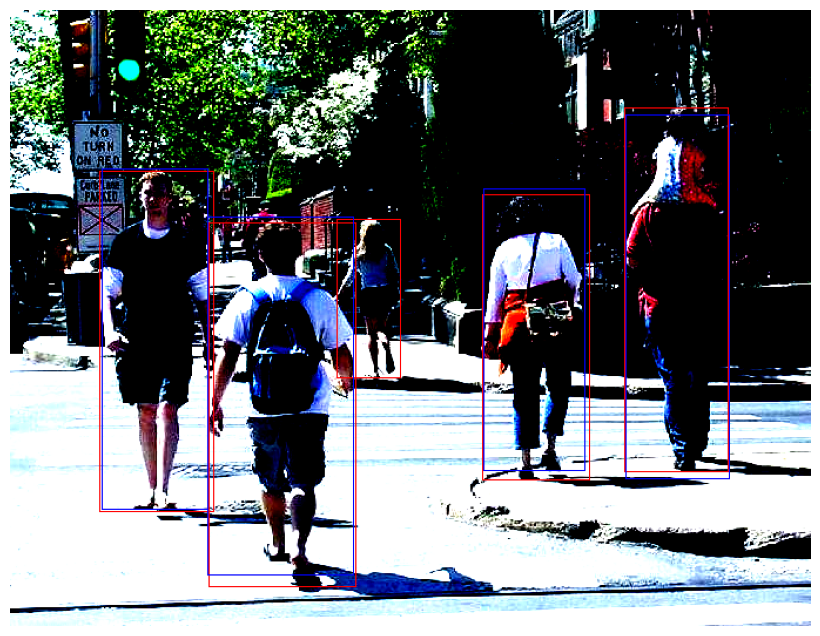

In [29]:

dataset = PennFudanDataset(f'{DATA_ROOT}/PennFudanPed')
valid_data_loader = DataLoader(
dataset,
batch_size=1,
shuffle=False,
num_workers=4,
collate_fn=collate_fn)


model = DETR_FineTune(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("./standard_backbone/detr_best_fold_5.pth"))
view_sample(dataset,model=model,device=torch.device('cuda'),idx=125)

In [31]:
from google.colab import files

# Assuming 'my_file.txt' is the name of the file you want to download
files.download('/content/r50.tar')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Statisical Analysis

In [29]:


from tensorboard.backend.event_processing import event_accumulator
from scipy import stats
import numpy as np


def compute_two_tailed_t_test(set_1, set_2, alpha=0.05):
    t_stat, p_value = stats.ttest_rel(set_1, set_2)

    print("Two-tailed Paired T-test Results")
    print("=" * 40)
    print(f"Set 1 mAP:  {np.mean(set_1):.4f} ± {np.std(set_1):.4f}")
    print(f"Set 2 mAP:  {np.mean(set_2):.4f} ± {np.std(set_2):.4f}")
    print(f"Difference:  {np.mean(set_1) - np.mean(set_2):.4f}")
    print(f"\nT-statistic: {t_stat:.4f}")
    print(f"P-value:     {p_value:.4f}")
    print(f"\nSignificant at α=0.05? {'Yes' if p_value < alpha else 'No'}")
    return t_stat,p_value


def extract_max_evals(dir: str = 'runs', num_folds: int = 5):

    max_values = []
    for fold in range(1,num_folds):
        ea = event_accumulator.EventAccumulator(
            f"{dir}/experiment_fold_{fold}")
        ea.Reload()

        # Find the val/map tag
        for tag in ea.Tags()['scalars']:
            if 'val' in tag.lower() and 'map' in tag.lower():
                values = [e.value for e in ea.Scalars(tag)]
                max_values.append(max(values))
                break
    return max_values




In [122]:
standard_model_results = extract_max_evals(dir='standard_backbone/runs')
resnet_101_backbone_results = extract_max_evals(dir='resnet_101/runs/')


x,y = compute_two_tailed_t_test(resnet_101_backbone_results,standard_model_results)

print(y)

Two-tailed Paired T-test Results
Set 1 mAP:  0.6866 ± 0.0187
Set 2 mAP:  0.6401 ± 0.0604
Difference:  0.0465

T-statistic: 1.3623
P-value:     0.2664

Significant at α=0.05? No
0.2663596090062016


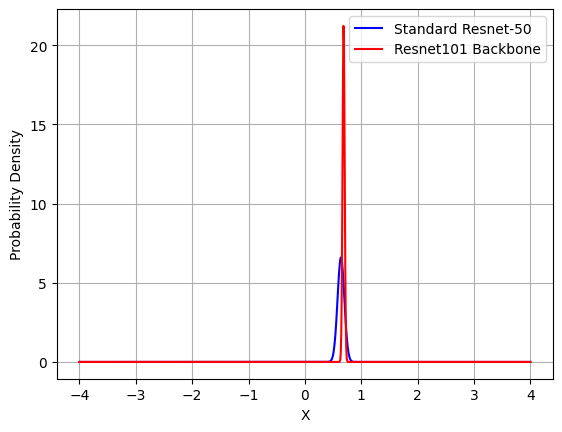

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm




standard_pdf = norm.pdf(np.linspace(-4, 4, 1000), loc=0.640, scale=0.0604)
r101_pdf = norm.pdf(np.linspace(-4, 4, 1000), loc=0.6866, scale=0.0187)

plt.plot(np.linspace(-4, 4, 1000), standard_pdf, 'b-', label='Standard Resnet-50')
plt.plot(np.linspace(-4, 4, 1000), r101_pdf, 'r-', label='Resnet101 Backbone')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

